# Access-Control Queuing Task

Example 10.2: An Access-Control Queuing Task This is a decision task involving
access control to a set of 10 servers. Customers of four di↵erent priorities arrive at a
single queue. If given access to a server, the customers pay a reward of 1, 2, 4, or 8 to
the server, depending on their priority, with higher priority customers paying more. In
each time step, the customer at the head of the queue is either accepted (assigned to one
of the servers) or rejected (removed from the queue, with a reward of zero). In either
case, on the next time step the next customer in the queue is considered. The queue
never empties, and the priorities of the customers in the queue are equally randomly
distributed. Of course a customer cannot be served if there is no free server; the customer
is always rejected in this case. Each busy server becomes free with probability p = 0.06
on each time step. Although we have just described them for definiteness, let us assume
the statistics of arrivals and departures are unknown. The task is to decide on each step
whether to accept or reject the next customer, on the basis of his priority and the number
of free servers, so as to maximize long-term reward without discounting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Enviroment

In [ ]:
class Server():
    
    def reset(self):
        self._n_free_servers = 10
        self._next_customer = self._create_next_customer()
        return (self._next_customer, self._n_free_servers)
        
    def step(self, action):
        if self._n_free_servers == 0 or action == 0:
            reward = 0
        else:
            reward = 2**self._next_customer
            self._n_free_servers -= 1
        self._free_servers()
        self._next_customer = self._create_next_customer()
        return reward, (self._next_customer, self._n_free_servers)
        
    def _free_servers(self):
        tmp = 10 - self._n_free_servers
        for _ in range(tmp):
            if np.random.rand() < 0.06:
                self._n_free_servers = min(10, self._n_free_servers+1)
        
    def _create_next_customer(self):
        return np.random.randint(4)

## Agent

In [3]:
def compute_eps_greedy_action(state, q, eps):
    if np.random.rand() < eps:
        return np.random.randint(2)
    else:
        return np.argmax(q[state[0],state[1], :])

In [4]:
q = np.zeros((4,11,2))

env = Server()
s = env.reset()
a = compute_eps_greedy_action(s, q, 0.1)
alpha = 0.01
beta = 0.01
eps = 0.5
r = 0
for i in range(2000000):
    if i % 200000 == 0:
        eps /= 2
    reward, next_state = env.step(a)
    next_action = compute_eps_greedy_action(next_state, q, eps)
    error = reward - r + q[next_state[0], next_state[1], next_action] - q[s[0], s[1], a]
    r += beta * error
    q[s[0], s[1], a] += alpha * error
    s = next_state
    a = next_action

## Results

In [11]:
print('The policy is:\n')
print(np.argmax(q, axis=2))

The policy is:

[[0 0 0 0 0 0 1 1 1 1 0]
 [1 0 0 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 1 0]]


The policy is mostly correct. Just the first row corresponding to the action taken in the case no server is idle is wrong, which doesn't matter since the next customer is always rejected. The values for the case with almost all servers idle is also not that good, which (as Sutton and Barto already mentioned) is probably due to the fact that these states are never visited. Using a higher probability to free a server these values are then also correct.

In [9]:
print('The mean reward is:')
print(r)

The mean reward is:
2.661332508936003


Text(0.5,1,'States values under the optimal policy')

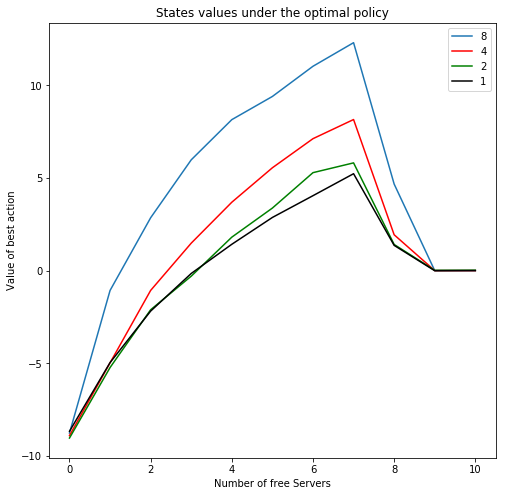

In [10]:
fig = plt.figure(figsize=(8,8))
plt.plot(np.arange(11), np.max(q[3,:,:], axis=1))
plt.plot(np.arange(11), np.max(q[2,:,:], axis=1), 'r')
plt.plot(np.arange(11), np.max(q[1,:,:], axis=1), 'g')
plt.plot(np.arange(11), np.max(q[0,:,:], axis=1), 'k')
plt.legend(['8','4', '2', '1'])
plt.xlabel('Number of free Servers')
plt.ylabel('Value of best action')
plt.title('States values under the optimal policy')